# Nesta Data Scientist Assignment
----

Submission: Julia Suter, March 2021

## Task Description 

(provided by Nesta)
> In this exercise, we ask you to explore how an established labour market framework
    can be used to start developing a map of jobs and skills. In this assignment you will
    work with the [European Skills, Competences, Qualifications and Occupations (ESCO)](https://ec.europa.eu/esco/portal)
    framework. ESCO has been developed by the European Commission and includes
    information on relationships between 2,942 occupations and 13,485
    skills/competences.
>    
> **Data**
>
>    The following datasets are provided:
 - **occupations_en.csv** contains information on 2,942 detailed occupations,
including alternative occupation titles and occupation descriptions. Note that
these occupations are aligned with a hierarchical occupational classification
International Standard Classification of Occupations (ISCO). The ISCO system
has four levels based on the number of digits in the code (with four digit
codes being the most finely grained classification and first digit being the
coarsest classification). The detailed occupations in the file represent a further
more granular level of the classification. The field ‘iscoGroup’ refers to the
code of the parent ISCO occupational group. The UK Standard Occupational
Classification closely resembles ISCO and has a similar structure.
>
>- **skills_en.csv** describes individual skills in the ESCO framework.
>
>
>- **ESCO_occup_skills.json** is a dictionary, where the title of a detailed ESCO
occupation serves as a key, and the description of this occupation is stored
as a set of nested dictionaries. This file provides a link between occupations
and skills that they require under label ‘_links’ and lists skills under further
nested dictionaries (‘hasEssentialSkill’ for essential skill requirements and
‘hasOptionalSkill’ for optional skills).
So, to extract essential skills for an occupation with the official title Broadcast
technician using Python from ESCO_occup_skills dictionary, you would use `
ESCO_occup_skills['broadcast technician']['_links']['hasEssentialSkill']`
>
>**Exercise**
>
>Using this data we would like you to carry out one of the following tasks:
>
>    **a) Build an alternative occupation classification.** We are asking you to
develop a data-driven categorisation of the 2,942 detailed occupations
to construct an alternative to the existing ISCO hierarchy. One possible
way to do that is to group occupations that have similar skill requirements.
As an example, one branch of a hierarchical occupation classification
could look like: 
>Health Professionals → Medical Practitioners → Doctor
   
>    **b) Build a skills taxonomy.** The objective of this task is to identify meaningful
groups of skills with a data driven approach. You might group skills that
occur together frequently or in similar contexts, or that are similar in
another way. As an example, one branch of a skills taxonomy could look
like: Computer skills → Software development skills → Python
>
>There are different ways to approach these problems. For example, you might use
tools from machine learning, natural language processing or network science.
There is no ‘right answer’ or single approach for either task, and we acknowledge
the limitations of the data.


## My Approach in a Nutshell


To tackle **Task b) Build a skills taxonomy**, we start by **loading and inspecting the provided data** and its structure. We build several **helper functions, classes and dictionaries and graphs** for easier processing at later stages. We also **visualize the ISCO structure** and its associated occupations to gain a better understanding. 

Using the generated circular tree ISCO graph and the information about skills, occupations and ISCO ID, we develop a **measure for calculating the relevance of a skill** at any given node in the ISCO graph, by adapting the *tf-idf* measure. The *tf-idf* represents the relevance of a skill with regards to the skills frequency and distribution across the graph. 

The *tf-idf* for skill at each node in the ISCO graph is used as a feature set. In order to fight the curse of dimensionality, we apply **dimensinality reduction using latent semantic analysis (LSA)**. We employ **k-means clustering** for finding groups of skills with similar features. 

Finally, for each skill in a cluster, we compute the two most similar skills by **computing the cosine similarity of the word embeddings** of their skill description. We **rank the skills by their *document frequency*** (collected at the feature engineering step), which allows the **creation of candidate branches in the taxonomy**.


###  Structure of this Jupyter Notebook<a id='top'></a>

This notebook shows a prototype for solving **Task b) Build a skills taxonomy**. It describes the entire process for developing this approach, including data analysis and some processing steps that are not necessary for the final pipeline. Some of the ideas and code blocks could also be utilize for solving Task a). 


- [Loading, Analysing and Preprocessing](#loading)
    - Load the data
    - Inspect the data
    - Preprocess and build dictionaries
    - Class for ISCO IDs
    - Get essential and option skills
    - Get skills for occupaton top group
        
        
- [Visualization](#visual)  
    - First visualization of occupations with ISCO similarity
    - Reduced ISCO graph for understanding ISCO structure
    - Full directed ISCO graph for futher computation
    
    
- [Feature Engineering](#feat)
    - Compute number leaf nodes for given node
    - Compute term frequency
    - Compute document frequency
    - Compute tf-idf feature array


- [Clustering](#cluster)

    - Reduce feature set
    - Scale features (MinMaxScaler)
    - Dimensionality reduction using LSA
    - k-means clustering
    - Load skills data and inspect clusters


- [Taxonomy](#tax)

    - Embed skill descriptions using word embeddings
    - Compute cosine similarity
    - Find most similar skills by description    
    - Use document frequency for ranking skills
    - Build taxonomy branches
    - Inspect results
    
    
- [Conclusion](#con)

## Loading and Inspecting Data<a id='loading'></a>
[[back to top]](#top)

    - Load the data
    - Inspect the data
    - Preprocess and build dictionaries
    - Class for ISCO IDs
    - Get essential and option skills
    - Get skills for occupaton top group

As a first step, we load the data, inspect and analyse it. We load the occupation and skill sets in a dataframe structure and we set up dictionaries that help connecting occupation, skill and ISCO ID. We also fix some input errors in the ISCO IDs.

### Imports

We require several libaries for this project. For data representation, we use `pandas`, `numpy` and `networkx`. For visualization, we require `networkx` and `matplotlib`. For dimensionality reduction and clustering, we employ `scikit-learn`. And for the NLP tasks of lemmatization and word embeddings, we require `nltk` and `gensim`.

You can find `requirements.txt` in the project folder.

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib import cm

from skills_taxonomy import get_yaml_config, Path

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


import skills_taxonomy.getters as getters
import skills_taxonomy.utils as utils
from skills_taxonomy.utils import plotting

from skills_taxonomy.pipeline import data_mapping, skills
from skills_taxonomy.pipeline.data_mapping import ISCO
from skills_taxonomy.pipeline import ISCO_graphs
from skills_taxonomy.pipeline import clustering, build_taxonomy_branches, word_embeddings

from ipywidgets import interact, interactive, Dropdown

### Occupation Data
Load occupations with ISCO ID, preferred and alternative labels, and descriptions. 
The occupations are very specific, e.g. *metal drawing machine operator* or *air traffic safety technician*. This is not surprising as they represent the most fine-grained ISCO level.

Note that there is only one value (*Occupation*) for the column `conceptType`, so this column represents no relevant information and should not be included when training a model on this data.

In [2]:
# Load occupations, skills and dict
occupations_df = getters.isco_esco_data.get_occupations()
skills_df = getters.isco_esco_data.get_skills()
occ_skill_dict = getters.isco_esco_data.get_occup_skill_dict()

print('Number of occupations: \t{}'.format(occupations_df.shape[0]))
print('Number of skills: \t{}'.format(skills_df.shape[0]))

Number of occupations: 	2942
Number of skills: 	13485


In [3]:
# Preview the first 5 lines of the loaded data 
occupations_df.head()

,conceptType,conceptUri,iscoGroup,preferredLabel,altLabels,description
0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2166,technical director,technical and operations director\nhead of tec...,Technical directors realise the artistic visio...
1,Occupation,http://data.europa.eu/esco/occupation/000e93a3...,8121,metal drawing machine operator,metal drawing machine technician\nmetal drawin...,Metal drawing machine operators set up and ope...
2,Occupation,http://data.europa.eu/esco/occupation/0019b951...,7543,precision device inspector,inspector of precision instruments\nprecision ...,Precision device inspectors make sure precisio...
3,Occupation,http://data.europa.eu/esco/occupation/0022f466...,3155,air traffic safety technician,air traffic safety electronics hardware specia...,Air traffic safety technicians provide technic...
4,Occupation,http://data.europa.eu/esco/occupation/002da35b...,2431,hospitality revenue manager,hospitality revenues manager\nyield manager\nh...,Hospitality revenue managers maximise revenue ...


### Unique ISCO IDs

There are 2942 occupations but only 426 ISCO IDs, which means that **several occupations share an ISCO ID**. Thus, the 4-digit ISCO ID does not represent one specific occupation but several similar professions.


### Fixing incomplete ISCO IDs
In this dataset, we find three ISCO IDs with **only 3 digits**. At first, we assumed that they simply represent slighly more general occupations. However, upon inspection, we find that they all represent various military professions and ranks, e.g. *colonel*, *brigadier*, *army corporal*, *air force pilot* and *infantry soldier*.

The top level occupation group for **Armed forces occupations** has the digit 0. We assume that the initial 0 was accidentally dropped when converting the data to a csv file, resulting in those incomplete 3 digit ISCO IDs. An easy fix for this problem is **prefixing them with a 0**, which brings all ISCO IDs into the same format and makes *Armed forces occupations* identifiable by their top level group index. (We apply this fix further down in the ISCO Class.)

# occupations: 2942
# unique ISCO IDs: 426

# short ISCO IDs: 3


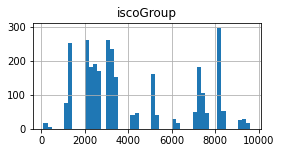

In [4]:
# How many different iscoGroups
print('# occupations: {}'.format(occupations_df.shape[0]))
print('# unique ISCO IDs: {}'.format(occupations_df['iscoGroup'].nunique()))
print()

# Get ISCO IDs with less than 4 digits
short_iscos = [isco for isco in occupations_df['iscoGroup'].unique() if len(str(isco))<4]

print('# short ISCO IDs: {}'.format(len(short_iscos)))

# Plot the histograms for the features 
isco_histo = occupations_df.hist(bins=50, figsize=(20,50), layout=(20,4))

### Skill Data
Load skills with type and reuse level, preferred and alternative labels, and descriptions.

As with the occupation dataframe, the *conceptType* shows only one value across all samples. The *skillType* has three different values: the most frequent is *skill/competence*, followed by *knowledge* and a single instance of *skill/competence knowledge*. This information can be useful for classifying skills, although we assume that not every skill can easily be divided into *knowledge* and *skill/competence*, as they often require both. How was it decided to which category they belong?

The *reuseLevel* has four different cateogories: *sector-specific*, *cross-sector*, *occupation-specific* and *transversal*. This could be useful for finding new occupations given a skill set.


In [5]:
# Preview the first 5 lines of the loaded data 
skills_df.head()

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,description
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,sector-specific,manage musical staff,manage staff of music\ncoordinate duties of mu...,Assign and manage staff tasks in areas such as...
1,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00064735-8fad...,skill/competence,occupation-specific,supervise correctional procedures,oversee prison procedures\nmanage correctional...,Supervise the operations of a correctional fac...
2,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/000709ed-2be5...,skill/competence,sector-specific,apply anti-oppressive practices,apply non-oppressive practices\napply an anti-...,"Identify oppression in societies, economies, c..."
3,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0007bdc2-dd15...,skill/competence,sector-specific,control compliance of railway vehicles regulat...,monitoring of compliance with railway vehicles...,"Inspect rolling stock, components and systems ..."
4,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00090cc1-1f27...,skill/competence,cross-sector,identify available services,establish available services\ndetermine rehabi...,Identify the different services available for ...


In [6]:
skills_df["skillType"].value_counts()

skill/competence              10582
knowledge                      2902
skill/competence knowledge        1
Name: skillType, dtype: int64

In [7]:
skills_df["reuseLevel"].value_counts()

sector-specific        6412
cross-sector           3643
occupation-specific    2977
transversal             453
Name: reuseLevel, dtype: int64

### Counts and Examples

Remember that we have three main types of data: **occupations, skill and ISCO IDs**. 
Here we print the number of unique values and several examples for each to get a better understanding.

In [8]:
# Get set of all unique occupations
occupation_set = sorted(set(occupations_df["preferredLabel"].values))
print('# occupations: {}'.format(len(occupation_set)))
print(occupation_set[:5])
print()

# Get set of all unique skills
skill_set = sorted(set(skills_df["preferredLabel"].values))
print('# skills: {}'.format(len(skill_set)))
print(skill_set[:5])
print()

# Get set of all unique occupations
isco_set = sorted(set(occupations_df["iscoGroup"].values))
print('# ISCO: {}'.format(len(isco_set)))
print(isco_set[:5])
print()

# occupations: 2942
['3D animator', '3D modeller', '3D printing technician', 'ATM repair technician', 'Freinet school teacher']

# skills: 13485
['3D body scanning technologies', '3D lighting', '3D modelling', '3D printing process', '3D texturing']

# ISCO: 426
[110, 210, 310, 1111, 1112]



### Essential and Optional Skills

Load the essential and optional skills for given occupation from the `ESCO_occup_skills.json`. The function below facilitates the retrieval. Below you can see some examples for required and optional skills. Note that **not every occupation has an optional skill set** and one occupation (*specialist dentist*) is even missing the essential skill set. 

In [9]:
# Get skills
print('Essential skills for technical director:')
print(skills.get_essential_skills("technical director"))
print()
print('Essential skills for air traffic safety technician:')
print(skills.get_essential_skills("air traffic safety technician"))
print()
print('Optional skills for air traffic safety technician:')
print(skills.get_optional_skills("air traffic safety technician"))
print()
print('All skills for air traffic safety technician:')
print(skills.get_all_skills("air traffic safety technician"))
print()
print('All skills for air traffic safety technician:')
print(skills.get_all_skills("career guidance advisor"))
print()

Essential skills for technical director:
["adapt to artists' creative demands", 'theatre techniques', 'organise rehearsals', 'negotiate health and safety issues with third parties', 'promote health and safety', 'write risk assessment on performing arts production', 'coordinate with creative departments', 'coordinate technical teams in artistic productions']

Essential skills for air traffic safety technician:
['safety engineering', 'install electrical and electronic equipment', 'maintain electronic equipment', 'airport safety regulations', 'electrical systems used in transportation', 'airport electrical systems', 'common aviation safety regulations', 'electronics', 'technical drawings', 'aircraft flight control systems', 'air transport law', 'comply with air traffic control operations', 'surveillance radars', 'ensure aircraft compliance with regulation', 'use testing equipment']

Optional skills for air traffic safety technician:
['air traffic management', 'use technical drawing softwa

In [10]:
# Get skills
print('Essential skills for technical director:')
print(skills.get_all_skills("data scientist"))


Essential skills for technical director:
['deliver visual presentation of data', 'resource description framework query language', 'information extraction', 'establish data processes', 'execute analytical mathematical calculations', 'data models', 'perform data cleansing', 'develop data processing applications', 'interpret current data', 'build recommender systems', 'manage data collection systems', 'collect ICT data', 'design database scheme', 'query languages', 'report analysis results', 'visual presentation techniques', 'data mining', 'information categorisation', 'handle data samples', 'statistics', 'implement data quality processes', 'online analytical processing', 'normalise data', 'manage data', 'perform data mining', 'LINQ', 'define data quality criteria', 'manage ICT data classification', 'N1QL', 'data quality assessment', 'unstructured data', 'manage ICT data architecture', 'MDX', 'SPARQL', 'create data models', 'business intelligence', 'integrate ICT data', 'XQuery', 'LDAP']


In [11]:
@interact(skill_type=['essential','optional','all'], occupation=sorted(occupation_set))
def get_skills(occupation, skill_type):
    
    print()
    print(f'{skill_type} skills for {occupation}:\n')
    print('- '+'\n- '.join(skills.get_skills(occupation, skill_type)))

interactive(children=(Dropdown(description='occupation', options=('3D animator', '3D modeller', '3D printing t…

### ISCO<a id='isco'></a>

The ISCO (International Standard Classification of Occupations) system has four levels based on the number of digits in the code (with four digit codes being the most finely grained classification and first digit being the coarsest classification). The coarest classification with its top level groups is displayed in the table below. 

**Example**:
Every occupation with an ISCO ID beginning with a `5` belongs to the *service and sales workers* group. The more refined ISCO ID of `52` represents *sales workers*, the even more refined ISCO ID of `521`  identifies *street and market salespersons* and the fine-grained 4-digit ISCO ID  `5211` represents *stall and market salespersons*.

| ISCO top level | Occupation Group |
| --- | --- |
| 0 | Armed forces occupations |
| 1 | Managers |
| 2 | Professionals |
| 3 | Technicians and associate professionals |
| 4 | Clerical support workers |
| 5 | Service and sales workers |
| 6 | Skilled agricultural, forestry and fishery workers |
| 7 | Craft and related trades workers |
| 8 | Plant and machine operators and assemblers |
| 9 | Elementary occupations |



We load the ISCO IDs as instances of the **ISCO class for easier processing and comparison**. At this point, we also **add the missing initial 0** for the *Armed forces occupations*. The ISCO class has 4 attributes representing the 4 different ISCO levels and provides a similarity function for **computing the similarity of two ISCO IDs**.

In [12]:
# ISCO instance examples
occ_1 = ISCO('123')  # needs to be padded with 0
occ_2 = ISCO('4321')
occ_3 = ISCO('4312')

print('Corrected IDs')
print(occ_1)
print(occ_2)
print(occ_3)
print()
print('Similarty based on ISCO levels')
print(occ_1, 'and', occ_2, '-->', occ_1.similarity(occ_2))
print(occ_2, 'and', occ_3, '-->', occ_2.similarity(occ_3))

Corrected IDs
0123
4321
4312

Similarty based on ISCO levels
0123 and 4321 --> 0
4321 and 4312 --> 2


### Helper Dictionaries

Here we set up dictionaries for connecting occupations, skills and ISCO IDs. An occupation has exactly one ISCO ID, but an ISCO ID can be associated with several occupations. Each occupation and thus each ISCO (representing several occupations) has a specific skill set. Finally, a skill can be assosciated with a set of occupations and ISCOs.

These dictionaries make it easier to map and collect information across occupations, skills and ISCOs.

We also find skills with missing essential and/or optional skills. And we discover that **22% of all skills are not associated with any occupation or ISCO**.

In [13]:
# Initialize skill dicts
link_dict, missing_dict = data_mapping.get_data_links(occupations_df, skills_df)


print('{} occupation with missing essential skill set:'.format(len(missing_dict['occ_with_miss_essent_skills'])))
print(missing_dict['occ_with_miss_essent_skills'])
print()

print('{} occupations with missing optional skill set:'.format(len(missing_dict['occ_with_miss_opt_skills'])))
print(missing_dict['occ_with_miss_opt_skills'][:5], '...')
print()

# Get skills with missing ISCO dicts
ratio_missing_isco_skills = round(len(missing_dict['skills_with_miss_ISCO'])/len(skill_set),2)*100
print('Skills not associated with any ISCO/occupation: {}%'.format(ratio_missing_isco_skills))
print(missing_dict['skills_with_miss_ISCO'][:5], '...')

1 occupation with missing essential skill set:
['specialist dentist']

223 occupations with missing optional skill set:
['agricultural machinery and equipment distribution manager', 'agricultural raw materials, seeds and animal feeds distribution manager', 'aircraft dispatcher', 'ammunition specialised seller', 'animal hydrotherapist'] ...

Skills not associated with any ISCO/occupation: 22.0%
['ABBYY FineReader', 'Absorb (learning management systems)', 'Adobe Photoshop Lightroom', 'Agile development', 'Agile project management'] ...


In [14]:
print("Get all occupations and ISCO IDs that require 'manage staff'")
print()
print(link_dict['skill_to_occup']['manage staff'][:5])
print(link_dict['skill_to_ISCO']['manage staff'][:5])
print()
print('Get occupation titles and skills for ISCO ID 7214')
print()
print(link_dict['ISCO_to_occup']['7214'])
print(link_dict['ISCO_to_skill']['7214'][:5])
print()
print('Get skills and ISCO ID for given occupation')
print()
print(link_dict['occup_to_ISCO']['data scientist'])
print(link_dict['occup_to_skill']['data scientist'][:5])

Get all occupations and ISCO IDs that require 'manage staff'

['ICT help desk manager', 'ICT operations manager', 'ICT project manager', 'ICT research manager', 'accommodation manager']
[<skills_taxonomy.pipeline.data_mapping.ISCO object at 0x7fa9e9192eb0>, <skills_taxonomy.pipeline.data_mapping.ISCO object at 0x7faa13028ac0>, <skills_taxonomy.pipeline.data_mapping.ISCO object at 0x7faa13028e80>, <skills_taxonomy.pipeline.data_mapping.ISCO object at 0x7faa13028460>, <skills_taxonomy.pipeline.data_mapping.ISCO object at 0x7faa13038640>]

Get occupation titles and skills for ISCO ID 7214

['dismantling worker', 'riveter', 'shipwright', 'structural ironworker']
['prepare ground for construction', 'use power tools', 'secure heavy construction equipment', 'follow health and safety procedures in construction', 'construct working platform']

Get skills and ISCO ID for given occupation

2511
['deliver visual presentation of data', 'resource description framework query language', 'information e

### Skills for Top Levels Occupation Groups

Here we show how to retrieve the skill sets for top level occupation groups, e.g. *Managers*, *Service and sales workers* and *Craft and related trades workers*. Select a group of interest and the essential skills needed for occupations in this group are returned.

In [15]:
# Set group of interest
sector_of_interest = "Craft and related trades workers"
sector_of_interest = 2

# Get skills for sector
sector_skills = data_mapping.get_skills_for_sector(sector_of_interest, isco_set, link_dict['ISCO_to_skill'])

# Print example
print("Skills for {}:\n".format(sector_of_interest))
print(sector_skills[:25])

Skills for 2:

['aerospace engineering', 'analyse experimental laboratory data', 'analyse scientific data', 'analyse telescope images', 'apply scientific methods', 'apply statistical analysis techniques', 'astronomy', 'carry out scientific research in observatory', 'define celestial bodies', 'design scientific equipment', 'execute analytical mathematical calculations', 'gather experimental data', 'laboratory techniques', 'mathematics', 'observe celestial objects', 'operate scientific measuring equipment', 'operate telescopes', 'perform laboratory tests', 'perform scientific research', 'physics', 'quantum mechanics', 'quantum optics', 'scientific research methodology', 'statistics', 'use measurement instruments']


## Visualizing Data<a id='visual'></a>
[[back to top]](#top)

    - Initial visualization of occupations with ISCO similarity
    - Reduced ISCO graph for understanding ISCO structure
    - Full directed ISCO graph for further computation

In this section, we visualize the occupations and ISCO hierachy to gain a better understanding of the data and find a good representation of the ISCO structure.

### First Visualization of Occupations

As a first visualization, we plot a subset of 100 occupations. The node colors represent the different top levels. The edge width shows show similar two occupations are according to their ISCO ID.

This graph shows a selection of occupations, **losely clustered by top level occupation group**. Nodes from the same cluster/top level naturally have **stronger connections since their ISCO ID is similar**. As an example, the occupations *gunsmith* and *tool and die maker* are very similar and thus show a strong edge width. Occupations of different top level groups show no connection at all.

The ISCO structure is not obvious in this graph since the ISCO similarity is only shown weakly in form of the edge widths. For better inspection of the ISCO hierarchy, we have to generate a tree graph.

### ISCO Graph (reduced)

This ISCO graph represents the ISCO levels and occupations as a circular tree. We only consider 100 occupations in this visualization to keep it readable. For the same reason, we only display one occupation per ISCO ID. The node colors represent the top level occupation groups.

The complete ISCO tree with all occupations is generated further down.

In [16]:
# Only process occupations with essential skills
occupations_to_process = [occ for occ in occupation_set if occ not in missing_dict['occ_with_miss_essent_skills']
        ]

# Create ISCO graph
G_ISCO_red = ISCO_graphs.create_circular_ISCO_graph(occupations_to_process, 
                                                                      link_dict, 
                                                                      reduced_occupation_set=True,
                                                                      only_one_leaf_node=True)

# Get node colors
node_colors = plotting.get_ISCO_node_colors(G_ISCO_red, link_dict["occup_to_ISCO"])

# Set figure size
plt.figure(figsize=(20,20))
plt.axis("equal")

# Get circular tree shape
circular_pos = graphviz_layout(G_ISCO_red, prog="twopi", args="")


# Draw graph
nx.draw(G_ISCO_red, circular_pos, node_size=500, alpha=0.8, node_color=node_colors, 
        cmap=cm.Paired, with_labels=True)


plt.show()


# Save figure
plotting.save_fig(plt, 'ISCO_graph_reduced')

AttributeError: module 'skills_taxonomy.utils.plotting' has no attribute 'get_ISCO_node_colors'

### Analysis

This graph shows the ISCO structure with its four levels. **Inner levels represent more general** ISCO IDs, **outer levels more specific** ones (1 digit in the center to 4 digits in the outer layer). The outermost nodes show one **example occupation** for the given 4-digit ISCO. The nodes are **colored by their top level** occupation groups, which is equal to the first digit in the ISCO. More information about ISCO and the respective top level category names can be found [here](#isco).

Only a fraction of the data is loaded by default so the number of nodes per top level category is not representative. However, this graph gives an idea of the diversity of each category shows some examples.

If the variable `complete_occ_set` is set to True, we can inspect the entire ISCO graph with all occupations and ISCO IDs, which is not as readable but represents all the data. The top level ***Armed forces occupations* (0) clearly has the smallest number** of ISCO IDS, followed by *Skilled agricultural, forestry and fishery workers* (6). This means that there are fewer occupations in those categories, which are possibly also less diverse.

The top levels ***Professionals* (2), *Technicians and assosciate professionals* (3) and *Craft and related trades workers* (7) have the widest array of occupations** and cover together more than half of the circular tree. Occupations in the top level *Professionals* range from *electian observer* to *ICT teacher*. For *Technicians and assosciate professionals*, occupations include *dental hygienist*, *police inspector* and *audio-visual technician*. The top level *Craft and related trades workers* ranges from *carper weaver* to *mining equipment mechanic*.

We learn that the different top levels are **unevenly distributed** across the ISCO structure. 

Note that the number of ISCO nodes does not necessarily represent the number of occupations associated with the top level category. However, further down we count the **number of occupations** for each category and find that it is **strongly correlated with the number of ISCO nodes**. *Armed forces occupations* and *Skilled agricultural, forestry and fishery workers* do indeed have the smallest occuaption set, while  *Professionals*, *Technicians and assosciate professionals* and *Craft and related trades workers* clearly hold the largest number of different occupations.

### ISCO Graph (full)

Here we compute the full directed ISCO graph with all occupations. It will help us compute the TF-IDF scores later on.

In [ ]:
# Create ISCO graph
G_ISCO_full = ISCO_graphs.create_circular_ISCO_graph(occupations_to_process, 
                                                                      link_dict, 
                                                                      reduced_occupation_set=False,
                                                                      only_one_leaf_node = False
                                                                          )

# Get node colors
node_colors =  plotting.get_ISCO_node_colors(G_ISCO_full, link_dict["occup_to_ISCO"])

# Set figure size
plt.figure(figsize=(20, 20))
plt.axis("equal")

# Get circular tree shape
circular_pos = graphviz_layout(G_ISCO_full, prog="twopi", args="")
node_labels = {label:label if len(label) <=4 else  '' for label in G_ISCO_full.nodes}

# Draw graph
nx.draw(G_ISCO_full, circular_pos, node_size=400, alpha=0.5,  node_color=node_colors, 
        cmap=cm.Paired, with_labels=True, labels=node_labels)

# Save figure
plotting.save_fig(plt, 'ISCO_graph_complete')

In [ ]:
print('Number of occupations by top level category')
print('-------------')
for key in ISCO_graphs.ID_top_level_dict.keys():   
    print("{} ({}): {}".format(ISCO_graphs.ID_top_level_dict[key], 
                               str(key), 
                               ISCO_graphs.get_n_leaf_nodes(G_ISCO_full, str(key))))

### Analysis 

This graph represents the full ISCO graph as a circular tree structure. We do not show the labels for reasons of readability. It shows nicely that **each 4-digit ISCO** (second outermost level) has its own **set of occupations** and that they can take different sizes.

## Feature Engineering<a id='feat'></a>
[[back to top]](#top)

- Compute number of leaf nodes for given node
- Compute term frequency
- Compute document frequency
- Compute tf-idf feature array


We want to find a way to compare and cluster the skills required for the various occupations. Since we have the ISCO structure and skills for each occupation and thus for each ISCO ID, we want to **compute the skill distribution over the entire ISCO graph**. We assume the following: if a skill is required for an occupation, then the skill is relevant for the occupation's ISCO ID - and to some extent also to the upper levels of this ISCO ID. 

If a specific skill A is required for an occupation with the ISCO ID `5123` but also for another occupation with the ISCO ID `5125`, then there are already two indicators for relevance of this skill at the ISCO node `512`. Very specific skills would only show high frequeuncy on the outer ISCO levels but not on the inner levels, while general skills are expected to be prevalent in the inner nodes as well. Specific skills would also appear more locally, while general skills are expected to be more distributed across the ISCO graph. 

### TF-IDF

We need to **measure how specific or general a given skill is and how much it required for each ISCO node**. This task is similar to the task of determining the relevance of a word in a document, with regards to its use in the entire set of documents. This common NLP task is usually resolved with the statistical method [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). *tf* stands for **term frequency**, *idf* stands for **inversed document frequency**. The *tf* reprents the frequency of a the word in the given document, while the *df* represents in how many documents this word appears. Thus, the *inversed df* gives higher relevance to words that are not very general and only occur in few documents.

In our case, the *term frequency* represents the **frequency of a specific skill requirement at any ISCO node**. Using the example above, skill A is relevant for two occupations leading up to ISCO node `512`. The frequency is computed by counting the occurences (i.e. 2) and diving it by the highest possible count, i.e. the number of leaf nodes for ISCO node `512` (all downstream occupation nodes at the outermost level). The **term frequency measures how relevant a skill is at given ISCO node** in comparison to other skills.

The *document frequency* represents here the **number of ISCO nodes that are affected by the skill requirement**. The additional association of skill A with ISCO ID `5123` affects the following nodes at different levels: `5123`, `512`, `51`, `5`. The association with `5125` adds only one new node to this set: `5125` itself. Thus, if skill A is spread more widely over the ISCO graph and is required for occupations with ISCO IDs of various top level categories, the document frequency will be higher than if the skill only affects occupations in the same part of the ISCO graph. Thus, the **document frequency computes how widely applicable or required a specific skill is across the ISCO graph**, with higher values indicating more general skills and lower values more specific skills.

For the computation of the **tf-idf**, we use the *inversed document frequency* in order to give more weight to specific skills. If a skill is very general, it should not affect the ISCO node as much. Thus, the *tf-idf* in regards to the skill distribution over the ISCO graph measures **how relevant a skill is at a given ISCO node**.

### Computing Number of Leaf Nodes and Term Frequency

Here we present two helper functions. One computes the number of leaf nodes for a given node in graph. It also helps with counting the numer of occupations per top level category.

The other function computes the term frequency of a skill in the ISCO graph.

In [ ]:
print('Leaf nodes for node 325:\t', ISCO_graphs.get_n_leaf_nodes(G_ISCO_full, '325'))
print('TF for node 73:\t\t\t', ISCO_graphs.get_tf(G_ISCO_full, '73', 'operate engraving equipment', link_dict["occup_to_skill"]))

### Preparing ISCO Features

Here we make preparations for the feature array. We have as many features as there are non-zero out-degree nodes (occupation nodes) in the ISCO graphs or, put more simply, the number of ISCO IDs plus their upper level nodes. 
We generate a dictionary for easily **mapping the ISCO node label to the respective index** in the feature array.

In [ ]:
# Map ISCO nodes to feature indices (for matching later)
ISCO_idx_dict, ISCO_nodes_dict, ISCO_level_n_dict = ISCO_graphs.map_ISCO_nodes_to_feat_indices(isco_set)

### Computing TF-IDF

Here we **compute the tf-idf for each skill at any node** in the ISCO graph. We **exclude the 20% of skills** that have no occupations/ISCO IDs associated with it since they would result in zero-only features.

For each skill, we first get all occupations that require the skill and all ISCO IDs for those occupations. For each ISCO ID, we then retrieve all four level ISCO nodes and the repsective indices in the feature array. For each node we compute the *term frequency* by computing **how many leaf nodes (occupations) a given ISCO node has and how many of them require that skill**. We also mark that this **node was affected by this skill** for computing the document frequency.

Finally, we compute the *tf-idf* for each skill at each node.

By default, we use the **precomputed** and saved numpy arrays for *tf-idf* and *document frequency*. For re-computation after altering the code, set `pre_computed` to False. The new results are saved automatically.

In [ ]:
# Set skills of interest (exclude those without associated ISCO)
skills_of_interest = [skill for skill in skill_set if skill not in missing_dict['skills_with_miss_ISCO']]
n_ISCO_nodes = ISCO_level_n_dict[4]
        
# Get tf-idf and df scores
tf_idf, df_dict = ISCO_graphs.compute_tf_idf(skills_of_interest, n_ISCO_nodes, 
                                             G_ISCO_full, ISCO_idx_dict, 
                                             link_dict, pre_computed=True)    

### Visualisation of TF-IDF Scores

In this circular ISCO graph, we visualise the TF-IDF score for a given skill (i.e. *manage staff*) by coloring ISCO nodes with a high TF-IDF score in darker red and nodes with low TF-IDF scores in lighter red to white. 

The graph shows nicely that the skill *manage staff* is most prominent in the the Sector *Managers*, as most of the dark red colored nodes can be found in nodes connected to that branch. Some occupations in other sectors may also require this skill but it's most common among in managing roles.

This combiantion of TF-IDF scores and the circular tree graph for the ISCO levels (and a possible extension thereof) can provide interesting insights into skills and the sectors they are required in. 

In [ ]:
# Visualise tf-idf scores across ISCO graph
clustering.visualise_tf_idf_for_skill(G_ISCO_full, tf_idf, ISCO_nodes_dict[4], skills_of_interest, 'manage staff')

## Clustering<a id='cluster'></a>
[[back to top]](#top)

    - Reduce feature set
    - Scale features (MinMaxScaler)
    - Dimensionality reduction using LSA
    - k-means clustering
    - Load skills data and inspect clusters

Now we want to cluster our skills according to the extracted *tf-idf* features. But first we have to load our data and reduce the feature space.

### Issue: High Dimensionality
Since we are facing a high-dimensional feature space, we first perform dimensionality reduction. One simple way of reducing the feature space is discarding the features of the most specific ISCO levels, leaving only the features for the **three more general levels**. This reduces feature space from 603 to 177.

As a second step, we perform dimensionality reduction using truncated SVD, also known as **[LSA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (latent semantic analysis)**. Contrary to PCA, it works **effectively on sparse matrices** and works especially well on **count-based matrices** - which is excatly what we need!

Alternatively, we implemented the PCA reduction, keeping the number of components relevant for an explained variance ratio of 90%. However, the LSA reduction is more suitable in this case. 


### Loading, Reducing and Scaling the features

We load the features, remove the outermost ISCO level features and scale our dating using a Min-Max-Scaler.

In [ ]:
print('Feature space before discarding outer level:', tf_idf.shape[1])

# Only retrieve features for first three ISCO levels
n_ISCO_up_to_3rd_level = ISCO_level_n_dict[3]
tf_idf_red = tf_idf[:, :n_ISCO_up_to_3rd_level]

print('Feature space after discarding outer level:', tf_idf_red.shape[1])

# Scale features
scaler = preprocessing.MinMaxScaler()
tf_idf_scaled = scaler.fit_transform(tf_idf_red)

### Explained Variance


We plot the explained variance ratio for the transformed data. 

### Dimensionality Reduction with PCA and LSA

We transform our feature set with PCA and LSA in order to reduce dimensionality. For PCA we use the number of components (97) that cover 90 percent of the explained variance ratio. For LSA we use 90 components since they cover a similar ratio.

In [ ]:
# Dimensionality reduction widget
dim_red_technique_widget = Dropdown(
    options=['LSA', 'PCA'],
    value='LSA',
    description='Dim. reduction technqiue:'
)

def get_dim_features(dim_red_technique):
    """Apply dimensionality reduction with either LSA or PCA."""
    
    if dim_red_technique == 'LSA':
        dim_reduced_features = clustering.dimensionality_reduction(tf_idf_scaled, 
                                                           dim_red_technique="lsa", 
                                                           lsa_n_comps=90,
                                                           random_state=42) 
    else:
        dim_reduced_features = clustering.dimensionality_reduction(tf_idf_scaled, 
                                                           dim_red_technique="pca", 
                                                           pca_expl_var_ratio=0.90,
                                                           random_state=42)
        
    return dim_reduced_features



# Dimensioanlity reduction 
dim_reduced_features = interactive(get_dim_features, dim_red_technique=dim_red_technique_widget)
display(dim_reduced_features)
dim_reduced_features = dim_reduced_features.result

print("Feature space before reduction:  {}".format(tf_idf_scaled.shape[1]))
print("Feature space after reduction:  {}".format(dim_reduced_features.shape[1]))

### K-means Clustering

Then we finally get to the clustering. We apply **k-means clustering** and set the **number of clusters to 15**, as we do not want too many different clusters for building our taxonomy. The plot shows that the formed clusters are not very clearly seperable but this is not unexpected for such a diverse and overlapping set of skills.

In [ ]:
# Apply k-means clustering
N_CLUSTERS = 15
kmeans = clustering.k_means_clustering(dim_reduced_features, n_clusters=N_CLUSTERS)

### Loading Skills with Cluster ID as Dataframe

Now that each skill is assigned to a cluster, we load the skills in a new dataframe together with all the collected information about skills.

We rank the skills by their document frequency (DF) and display the head and tail of the list for comparison. The **skills with high DF are - as expected - very general**, for instance *create solutions to problems* or *manage staff* or *listen actively*, while the **skills with low DF are more specific**, such as *administer multi-modal logistics* or *XQuery* or *split animal carcasses*. Therefore, we conclude that DF measures what we expected it to measure: the generality of the skill.

In [ ]:
# Get upated skill df
updated_skill_df, skill_mapping_dicts = clustering.get_updated_skill_df(skills_df, skills_of_interest, df_dict, kmeans)
updated_skill_df.head(80)

### Cluster Analysis

Below we see a selection of skills for each of the 15 clusters. **Skills for similar occupations often seem to be clustered together**, as expected when using the ISCO graph for feature engineering. We would have hoped for one or two clusters with more general skills (e.g. *manage staff*, *create solutiosn to problems*) but they seem to be intermixed with other more specific skills. In general, the clusters seem to contain **meaningful** sets of skill. We have to use the DF for identifying general skills.
It would be interesting to investigate to what extent the clusters include skills asscociated with different top level categories. Unfortunately, we did not manage due to time constraints.

Here are some examples for the different clusters:

**Cluster 2** is a collection of skills used when working animals, e.g. *assess animal behaviour* or *prescribe physical therapy to animals* or *certify the performance of veterinary procedures*.

**Cluster 7** contains skill connected to fishing and farming, e.g. *stock fish into holding units* or *prepare planting area for planting*.

**Cluster 8** collect teaching skills, e.g. *curriculum objectives* or *adapt teaching to student's capabilities*.

**Cluster 10** contains sales skills, e.g. *characteristics of products* or *monitor stock level* or *organise product display*.

**Cluster 13** consists of logistic skills, e.g. *manage truck drivers*, *supervise unloading of cargo* and *health and safety measures in transportation*.

In [ ]:
# Print clusters and their skills
for cluster in range(N_CLUSTERS):
    print('Cluster', cluster)
    print(skill_mapping_dicts['cluster to skill'][cluster][:20])
    print()

## Taxonomy Creation<a id='tax'></a>
[[back to top]](#top)

    - Embed skill descriptions using word embeddings
    - Compute cosine similarity
    - Find most similar skills by description    
    - Use document frequency for ranking skills
    - Build taxonomy branches
    - Inspect results

Finally, we build a new **skill taxonomy**. We divide the skills by their clusters and process the sets independently. We find the **two most similar skills** for each skill by computing the **cosine similarity of the word embeddings of their skill description**. We then use the **document frequency (DF) for ranking** the skills by generality and **generating new taxonomy branches**, e.g. signs of animal illness --> monitor the welfare of animals --> advise on animal welfare.


### Word Embeddings

For the embedding of the descriptions, we use pretrained `word2vec` with 300 dimensions. We only consider the tokens in the description that are **nouns, verbs or adjectives**, as they are most descriptive. We retrieve the embedding those tokens (lemmatized if not found otherwise) and compute the **mean over all word embeddings** as the representation of the entire description.

In [ ]:
# Load word2vec model
WORD2VEC = word_embeddings.load_word2vec()

### Finding Taxonomy Branches

For each skill cluster, we find new taxonomy branches. Note that we do not intermix skills for different clusters. For each skill, we find the **two most similar skills by computing the cosine similarity of the word embeddings of their descriptions**. Then, we **rank the skill triple** (the original skill and the two similar skills) **by descending document frequency**, leaving the more general skills first and the more specific skills last.

If the skills have different DFs, we return add them as a **new branch to the taxonomy**. If two skills have the same DF, we consider them as similar and add them as **skill snyonyms to the taxonomy**.

In [ ]:
# Set clusters of interest
clusters_of_interest = [2, 4, 8, 10]

# Retrieve skill hierarchy and syonym branches
skill_hierarchy, synonym_skills = build_taxonomy_branches.get_skill_tax_branches(clusters_of_interest, 
                                                                                  updated_skill_df, 
                                                                                  df_dict, 
                                                                                  skill_mapping_dicts['desc to skill'], 
                                                                                  WORD2VEC=WORD2VEC)

In [ ]:
# Print examples
print('Taxonomy branch examples:\n')
for skills in skill_hierarchy[:25]:
    print(' --> '.join(skills))

In [ ]:
# Print synonym skill examples
for skills in synonym_skills[:25]:
    print(' <--> '.join(skills))

### Taxonomy Branches

Above we see a selection of proposed taxonomy branches. Some are quite reasonable while others are not yet ideal. Needless to say, **these taxonomy branches should be further refined and more carefully selected**. This is merely a prototype. However, it shows the **potential for a meaningful skill taxonomy**.


Here are some good examples:
```
art history --> understand artistic concepts
maintain audiovisual equipment --> perform technical sound check --> manage sound quality
signs of animal illness --> monitor the welfare of animals --> advise on animal welfare
process payments --> issue sales invoices --> operate cash register
observe student's progress --> adapt teaching to student's capabilities --> assess students

```
*Art history* is more general than *understanding artistic concepts*. *Mainining audiovisual equipment* is a more general skill than *performing technical sound check* or even *managing sound quality*. As for the third example, one has to know the *signs of animal illness* before one can *monitor the welfare of animals* or give *advice on animal welfare*. *Processing payments* is more general than *issueing sales invoices* or more specifically *operating the cash register*. And finally, *oberserving student's progess* is a pre-step to *adapting teaching to sutdent's capabilities* and *assessing students*.

Here are some bad examples:

```
translate artistic concepts to technical designs --> understand artistic concepts --> develop design ideas cooperatively
labour legislation --> adapt to type of media --> confer on artwork
perform gross post mortem examination on animals --> advise on livestock disease control
assist students in their learning --> perform classroom management -->  liaise with educational staff
```

*Understanding artistic concepts* should be more general than *translating artistic concepts to technical designs*. The *developing of design ideas cooperatively*, however, seems to be a valid subskill for *understanding artistic concepts*.  The skills in the second example do not even seem to fit together well, same as for the third example. The final examples show three skills of the same category but since they are all very vague it is hard to assess whether this triple is reasonable.

Most of the time, the triples are represent skills from the same field, so the **clustering and cosine similarity can be considered successful**. However, they are often **not direct descendants** of each other, even if differently orderd. Therefore, the **main challenge is finding skills are that actually related in a hierarchical way**. The word embeddings of the skill descriptions may not be the ideal solution for retrieving hierarchical triples. However, we find that the **document frequency** is a good measure for **skill generality** and manages to sort actual hierarchical triples well.

We also computed skill synonyms. Those do not have a hierarchical structure but would be siblings (or label alternatives) in the taxonomy. Here show a couple of examples:

Good examples:
```
operate sound live <--> mix sound in a live situation
confer on artwork <--> interpret artistic intentions
provide anaesthetics to animals <--> provide sedation to animals

```

Bad examples:
```
perform veterinary diagnosis <--> provide sedation to animals
research new ideas <--> verify feasibility
record music <--> perform soundchecks
```

Appearently, our method finds some high-quality skill synonyms but fails in other cases. The **document frequeny is probably not ideal for identifying synonyms** and more weight should be given to the **cosine similarity of the word embeddings**.

### Taxonomy Graph

Here we generate the **directed taxonomy graph** based on the taxonomy branches. It is not yet a complete and clean taxonomy in a tree form, but it is a **good starting point** for creating one. The clusters provide a first level division of the skills. The merged taxonomy branches then provide the hierarchical structure. 

The node colors represent the cluster ID and the directed edges show the decending level of hierarchy. We only plot a selection of the branches from different clusters in order to maintain readabilty.

In [ ]:
build_taxonomy_branches.visualise_taxonomy_branches(skill_hierarchy, skill_mapping_dicts["skill to cluster"], directed_graph=True, every_nth_sample=20)

### Skill Synonyms Graph

This graph shows *skill synonyms*. Those skills have very **similar skill descriptions** accorcding to their word embeddings and **identical document frequency** (= generality level). They do not necessarily have to be synonyms but should be similar in their application. Examples are *study media sources* and *research new ideas* or the triple *perform technical soundcheck*, *assess sound quality* and *coordinate activities in audio recording studio*.

In [ ]:
build_taxonomy_branches.visualise_taxonomy_branches(synonym_skills, skill_mapping_dicts["skill to cluster"], directed_graph=False, every_nth_sample=10)

## Conclusion and Outlook<a id='con'></a>
[[back to top]](#top)

In this notebook, we have described and implemented an approach for **generating a new taxonomy for skills**. We have loaded and analysed the data and even **fixed some errors** (3-digit ISCO IDs). We have visualized the data and the ISCO hierarchy. We have extracted *tf-idf* features for each skill and ISCO node and used those features for clustering the skills into reasonably meaningful groups of skills. Finally, extracted **taxonomy branches** including **skill synomyms** by utilizing word embeddings of skill descriptions and the document frequency.

We have found that many of the returned taxonomy branches are meaningful in the sense that they represent skills of the same field. Some even show **valuable hierachical structure**. However, many others are **not related in a hierarchical way**, even when sorted differently. Therefore, we must find an alternative way for **identifying related skill pairs of different taxonomy levels**. 

In order to solve this, we could use the ISCO levels and the term and document frequency for identifying skill pairs that occur in **similar contexts but are prevalent at different levels**. One could also try to measure **how much one skill covers another** (e.g. in terms of how many nodes or occupations) and use this informatiion for generating a hierarchy. 

We could also utilize the skill's *reuseLevel* categories (*sector-specific*, *cross-sector*, *occupation-specific* and *transversal*) as they may hold information about a skill's generality level and its position in the taxonomy. And we could pre-sort the skills into *skill/competence* and *knowledge* type, which could help building a more refined taxnomy.

Furthermore, we could use **topic modeling** based on the skill descriptions (and/or the associated job descriptions) for **retrieving main and sub categories** for the taxonomy and grouping the skills.  Finally, we could try to employ **hierarchical clustering** for building the taxonomy based on the extracted features and the information we have on skills, occupations and ISCO IDs.

Due to time constraints, we only managed to develop a **prototype** for building a new taxonomy. Still, we gained insight in the data and learned about possible ways to address this problem.

**Thank you for this exciting assessment, Nesta!**